# External Source Operator - basic usage

In this example, we will show you how to use the `ExternalSource` operator, so that you can
use an external data source as an input to the pipeline.

In [1]:
import types
import collections
import numpy as np
from random import shuffle
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types

batch_size = 16

### Define the Data Source
In this example, we will use an infinite iterator as a data source.

In [2]:
class ExternalInputIterator(object):
    def __init__(self, batch_size):
        self.images_dir = "../../data/images/"
        self.batch_size = batch_size
        with open(self.images_dir + "file_list.txt", "r") as f:
            self.files = [line.rstrip() for line in f if line != ""]
        shuffle(self.files)

    def __iter__(self):
        self.i = 0
        self.n = len(self.files)
        return self

    def __next__(self):
        batch = []
        labels = []
        for _ in range(self.batch_size):
            jpeg_filename, label = self.files[self.i].split(" ")
            f = open(self.images_dir + jpeg_filename, "rb")
            batch.append(np.frombuffer(f.read(), dtype=np.uint8))
            labels.append(np.array([label], dtype=np.uint8))
            self.i = (self.i + 1) % self.n
        return (batch, labels)

<div class="alert alert-block alert-warning">
<b>Warning</b>

When the pipeline has conditional execution enabled, additional steps must be taken to prevent the `source` from being rewritten by AutoGraph.
There are two ways to achieve this:
1. Define the function at global scope (i.e. outside of `pipeline_def` scope).
2. If function is a result of another "factory" function, then the factory function must be defined outside pipeline definition function and decorated with `<nvidia.dali.pipeline.do_not_convert>`.

More details can be found in `nvidia.dali.pipeline.do_not_convert` documentation.
</div>

### Defining the Pipeline

The next step is to define the Pipeline.

The `ExternalSource` operator accepts an iterable or a callable. If the source provides multiple outputs (for example images and labels), that number must also be specified as the `num_outputs` argument.

Internally, the pipeline will call `source` (if callable) or run `next(source)` (if iterable) when additional data is needed to keep the pipeline running.

In [3]:
eii = ExternalInputIterator(batch_size)

In [4]:
pipe = Pipeline(batch_size=batch_size, num_threads=2, device_id=0)
with pipe:
    jpegs, labels = fn.external_source(
        source=eii, num_outputs=2, dtype=types.UINT8
    )
    decode = fn.decoders.image(jpegs, device="mixed", output_type=types.RGB)
    enhance = fn.brightness_contrast(decode, contrast=2)
    pipe.set_outputs(enhance, labels)

### Using the Pipeline

In [5]:
pipe.build()
pipe_out = pipe.run()

Here, the labels are still in the memory and no `as_cpu` call is needed to show the labels.

In [6]:
batch_cpu = pipe_out[0].as_cpu()
labels_cpu = pipe_out[1]

(427, 640, 3)
[1]


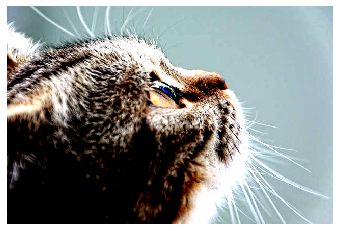

In [7]:
import matplotlib.pyplot as plt

img = batch_cpu.at(2)
print(img.shape)
print(labels_cpu.at(2))
plt.axis("off")
plt.imshow(img)

## Interacting with the GPU Input

The external source operator can also accept GPU data from CuPy or any other data source that supports the [cuda array interface](https://numba.pydata.org/numba-doc/latest/cuda/cuda_array_interface.html).
For this example, we create the `ExternalInputGpuIterator` that returns data on the GPU. Since `decoders.image` does not accept data on the GPU we need to decode it outside DALI on the CPU and then move it to the GPU. Typically, because of the operation of another library, the image; or other data will already be on the GPU.

In [8]:
import cupy as cp
import imageio


class ExternalInputGpuIterator(object):
    def __init__(self, batch_size):
        self.images_dir = "../../data/images/"
        self.batch_size = batch_size
        with open(self.images_dir + "file_list.txt", "r") as f:
            self.files = [line.rstrip() for line in f if line != ""]
        shuffle(self.files)

    def __iter__(self):
        self.i = 0
        self.n = len(self.files)
        return self

    def __next__(self):
        batch = []
        labels = []
        for _ in range(self.batch_size):
            jpeg_filename, label = self.files[self.i].split(" ")
            im = imageio.imread(self.images_dir + jpeg_filename)
            im = cp.asarray(im)
            im = im * 0.6
            batch.append(im.astype(cp.uint8))
            labels.append(cp.array([label], dtype=np.uint8))
            self.i = (self.i + 1) % self.n
        return (batch, labels)

1. Let us modify the previous pipeline by using the GPU version of the ExternalSource operator and remove the decoding 

   **Note**: We assume that the raw image is already on the GPU.

In [9]:
eii_gpu = ExternalInputGpuIterator(batch_size)

print(type(next(iter(eii_gpu))[0][0]))

<class 'cupy.core.core.ndarray'>


In [10]:
pipe_gpu = Pipeline(batch_size=batch_size, num_threads=2, device_id=0)
with pipe_gpu:
    images, labels = fn.external_source(
        source=eii_gpu, num_outputs=2, device="gpu", dtype=types.UINT8
    )
    enhance = fn.brightness_contrast(images, contrast=2)
    pipe_gpu.set_outputs(enhance, labels)

pipe_gpu.build()

2. Visualize the results:

(480, 640, 3)
[1]


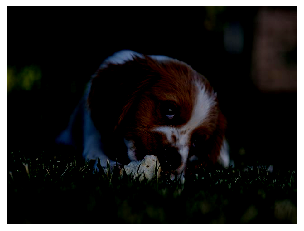

In [11]:
pipe_out_gpu = pipe_gpu.run()
batch_gpu = pipe_out_gpu[0].as_cpu()
labels_gpu = pipe_out_gpu[1].as_cpu()

img = batch_gpu.at(2)
print(img.shape)
print(labels_cpu.at(2))
plt.axis("off")
plt.imshow(img)